In [ ]:
! pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.3 MB/s eta 0:00:00


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import random
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import torchvision.transforms.functional as tf
import rasterio

# for the tiff things https://discuss.pytorch.org/t/training-a-cnn-with-tiff-images-in-pytorch/9531/4

In [ ]:
# loading fpn model
fpn = smp.FPN(encoder_weights='imagenet', in_channels=4,classes=1,activation='sigmoid')
_ = fpn.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
# based on https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html

class CustomImageDataset(Dataset):
  """
  Dataset class for TIF images (reads both .tif and .tiff) with labels.

  Attributes:
  img_dir (str) - path to the directory of the imported images
  mask_dir (str) - path to the directory of the imported labels
  transform (callable) - transform function to be performed on data
  img_files (list) - list of all the image files from the directory

  Methods:
  init - Initializes the object.
  len - Returns the length of the data.
  getitem - Returns and transforms (if applicable) an image from the dataset.
  """
  def __init__(self, img_dir, mask_dir, transform=None):

      self.img_dir = img_dir
      self.mask_dir = mask_dir
      self.transform = transform
      self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.tif')] # instead of the annotations from the other dataset, from claude

  def __len__(self):
      return len(self.img_files)

  def __getitem__(self, idx):
      img_path = os.path.join(self.img_dir, self.img_files[idx])
      mask_path = os.path.join(self.mask_dir, self.img_files[idx])

      with rasterio.open(img_path) as src:
          image = src.read()
          image = np.transpose(image, (1, 2, 0)) # changing the channel order, needed
          image = image.astype(np.float32) / 10000.0 # sentinel uses 0-10000 values for each pixel, normalization

      with rasterio.open(mask_path) as src:
          label = src.read(1).astype(np.float32)


      if self.transform:
          image, label = self.transform(image, label)

      return image, label

In [ ]:
#mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

src_folder = '/content/drive/MyDrive/AMAZON'
dest_folder = '/content/local_amazon_data'


!mkdir -p {dest_folder}
!cp -rv "{src_folder}/." "{dest_folder}"

'/content/drive/MyDrive/AMAZON/./.DS_Store' -> '/content/local_amazon_data/./.DS_Store'
'/content/drive/MyDrive/AMAZON/./Validation' -> '/content/local_amazon_data/./Validation'
'/content/drive/MyDrive/AMAZON/./Validation/.DS_Store' -> '/content/local_amazon_data/./Validation/.DS_Store'
'/content/drive/MyDrive/AMAZON/./Validation/images' -> '/content/local_amazon_data/./Validation/images'
'/content/drive/MyDrive/AMAZON/./Validation/images/S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_01_04.tif' -> '/content/local_amazon_data/./Validation/images/S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_01_04.tif'
'/content/drive/MyDrive/AMAZON/./Validation/images/S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_01_05.tif' -> '/content/local_amazon_data/./Validation/images/S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_01_05.tif'
'/content/drive/MyDrive/AMAZON/./Validation/images/S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_01_1

In [ ]:
def random_transforms(img,mask):
  """
  Randomly transforms the image and its mask accordingly.
  Input:
  img (PIL Image) - image to be segmentated
  mask (PIL Image) - mask for validation of segmentation of the image
  Output:
  img (torch.tensor) - transformed image
  mask (torch.tensor) - transformed mask
  """
  img = tf.to_tensor(img)
  mask = tf.to_tensor(mask)

  r = random.random()
  if r > 0.5:
    pass
  elif r > 0.25:
    img = tf.hflip(img)
    mask = tf.hflip(mask)
  else:
    img = tf.vflip(img)
    mask = tf.vflip(mask)

  angles = [0, 90, 180, 270]
  angle = random.choice(angles)
  img = tf.rotate(img, angle)
  mask = tf.rotate(mask, angle)

  return img, mask

def validation_transforms(img, mask):
  """
  Transforms the image and its mask to tensor.
  Input:
  img (PIL Image) - image to be segmentated
  mask (PIL Image) - mask for validation of segmentation of the image
  Output:
  img (torch.tensor) - transformed image
  mask (torch.tensor) - transformed mask
  """
  img = tf.to_tensor(img)
  mask = tf.to_tensor(mask)

  return img, mask

In [ ]:
# data import
train_img_path = '/content/local_amazon_data/Training/image'
train_mask_path = '/content/local_amazon_data/Training/label'

val_img_path = '/content/local_amazon_data/Validation/images'
val_mask_path = '/content/local_amazon_data/Validation/masks'

train = CustomImageDataset(train_img_path,train_mask_path,random_transforms)
val = CustomImageDataset(val_img_path,val_mask_path,validation_transforms)

train_dataloader = DataLoader(train, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val, batch_size=8, shuffle=True)

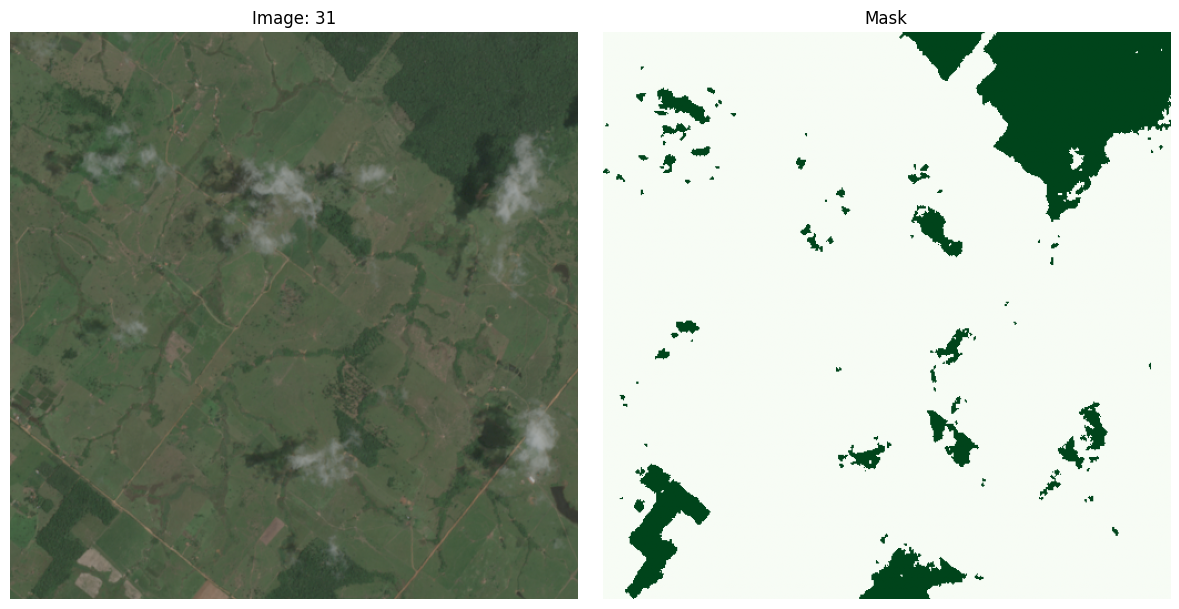

In [ ]:
# stolen from rocco
def visualize_random_sample(dataset):
    # visualize random sample
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]

    img_plot = image[:3, :, :].permute(1, 2, 0).numpy() # only 3 channels rgb
    img_plot = np.clip(img_plot, 0, 1)
    img_plot = np.power(img_plot, 0.4) # boost brightmess, after normalization plot gets dim
    mask_plot = mask.squeeze().numpy()

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img_plot)
    plt.title(f"Image: {idx}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_plot, cmap='Greens') # 'Greens' o 'gray' para ver el contraste
    plt.title("Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_random_sample(val)

In [ ]:
  # based on https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html adjusted for segmentation

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)

    best_loss = np.inf
    best_model_params_path = 'best_model.pth'

    # initializing variables for model measures
    train_losses, train_ious = [],[]
    val_losses, val_ious = [],[]

    for epoch in range(num_epochs):
      print(f'Epoch {epoch+1}/{num_epochs}')
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set model to training mode
              dataloader = train_dataloader
          else:
              model.eval()   # Set model to evaluate mode
              dataloader = val_dataloader

          # resetting measure variables at the start of each epoch
          running_loss = 0.0
          total_iou = 0.0

          # Iterate over data.
          for inputs, labels in dataloader:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()


              # statistics
              tp, fp, fn, tn = smp.metrics.get_stats((outputs > 0.5).long(), labels.long(), mode='binary')
              iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
              total_iou += iou.item() * inputs.size(0)
              running_loss += loss.item() * inputs.size(0)

          epoch_loss = running_loss / len(dataloader.dataset)
          epoch_iou = total_iou / len(dataloader.dataset)

          print(f'{phase} Loss: {epoch_loss:.4f}\n')

          if phase == 'train':
              train_losses.append(epoch_loss)
              train_ious.append(epoch_iou)
          else:
              val_losses.append(epoch_loss)
              val_ious.append(epoch_iou)

          # deep copy the model
          if phase == 'val' and epoch_loss < best_loss:
              best_loss = epoch_loss
              torch.save(model.state_dict(), best_model_params_path)

      scheduler.step(epoch_loss) # step after each epoch

    model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    return model, [train_losses, val_losses, train_ious, val_ious]

model = fpn
criterion = smp.losses.DiceLoss(mode='binary') #loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer) # it plateaued in the first couple of runs, so aproppriate scheduler

trained_model, stats = train_model(model, criterion, optimizer, scheduler, num_epochs=25)
torch.save(trained_model, '/content/drive/MyDrive/MODELS/fpn_amazon.pth')

Using device: cuda
Epoch 1/25
----------
train Loss: 0.3532

val Loss: 0.3479

Epoch 2/25
----------
train Loss: 0.3445

val Loss: 0.3459

Epoch 3/25
----------
train Loss: 0.3438

val Loss: 0.3452

Epoch 4/25
----------
train Loss: 0.3444

val Loss: 0.3480

Epoch 5/25
----------
train Loss: 0.3449

val Loss: 0.3451

Epoch 6/25
----------
train Loss: 0.3457

val Loss: 0.3447

Epoch 7/25
----------
train Loss: 0.3442

val Loss: 0.3447

Epoch 8/25
----------
train Loss: 0.3426

val Loss: 0.3435

Epoch 9/25
----------
train Loss: 0.3416

val Loss: 0.3460

Epoch 10/25
----------
train Loss: 0.3426

val Loss: 0.3455

Epoch 11/25
----------
train Loss: 0.3425

val Loss: 0.3516

Epoch 12/25
----------
train Loss: 0.3429

val Loss: 0.3435

Epoch 13/25
----------
train Loss: 0.3442

val Loss: 0.3531

Epoch 14/25
----------
train Loss: 0.3433

val Loss: 0.3468

Epoch 15/25
----------
train Loss: 0.3404

val Loss: 0.3503

Epoch 16/25
----------
train Loss: 0.3448

val Loss: 0.3448

Epoch 17/25
--

In [ ]:
! ls

best_model.pth	drive  local_amazon_data  local_atlantic_data  sample_data


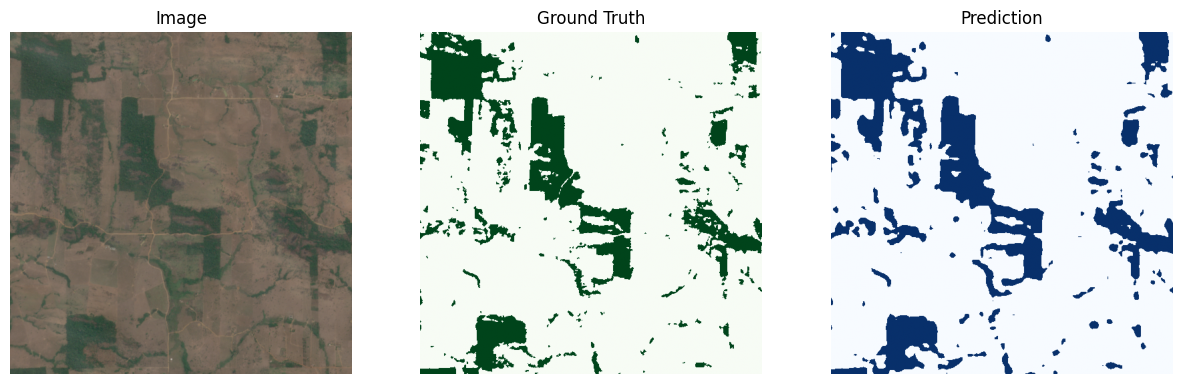

In [ ]:
# yoink
def test_prediction(dataset, model, device):
    model.eval()
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]

    # Preparar imagen para el modelo (añadir dimensión de batch)
    input_img = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_img)
        # Convertir probabilidad a máscara binaria (umbral 0.5)
        pred_mask = (output > 0.5).float().cpu().squeeze().numpy()

    # Preparar para graficar
    img_plot = image[:3, :, :].permute(1, 2, 0).numpy() # only 3 channels rgb
    img_plot = np.clip(img_plot, 0, 1)
    img_plot = np.power(img_plot, 0.4) # boost brightmess, after normalization plot gets dim
    true_mask = mask.squeeze().numpy()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img_plot)
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='Greens')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='Blues')
    plt.title("Prediction")
    plt.axis('off')

    plt.show()

# Cargar el mejor modelo antes de probar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('best_model.pth'))
test_prediction(val, model, device)

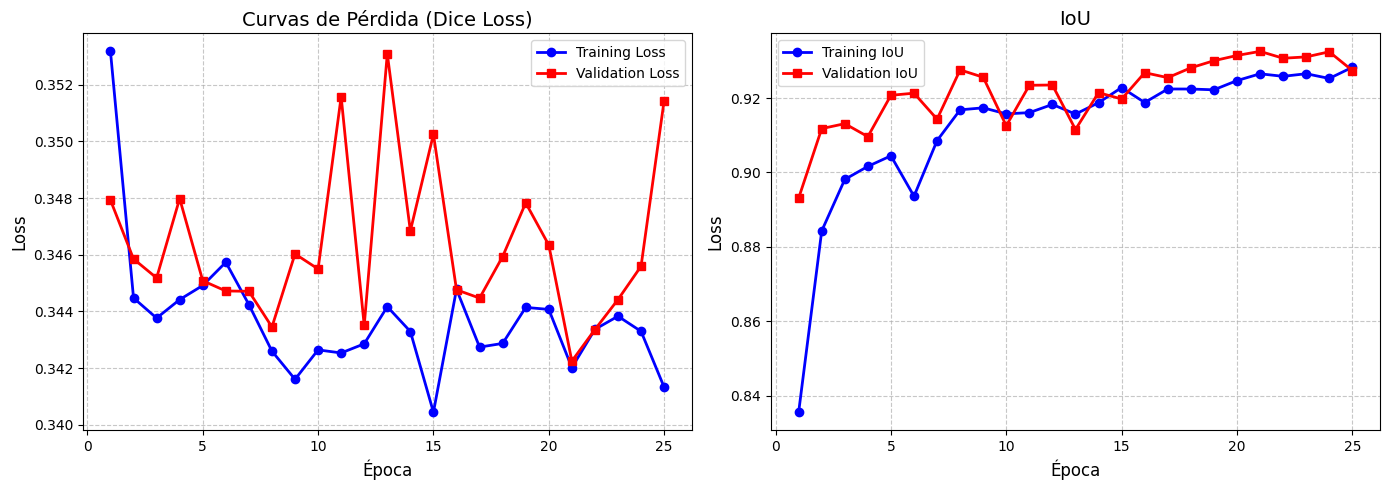

In [ ]:
# again
train_losses = stats[0]
val_losses = stats[1]
train_ious = stats[2]
val_ious = stats[3]
# --- DATOS EXTRAÍDOS DE TUS LOGS ---
epochs = list(range(1, 26))

# --- CREACIÓN DEL GRÁFICO ---
fig,ax = plt.subplots(figsize=(14, 5), ncols=2)

# Curvas de Pérdida (Loss)
ax[0].plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2)
ax[0].plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2)
ax[0].set_title('Curvas de Pérdida (Dice Loss)', fontsize=14)
ax[0].set_xlabel('Época', fontsize=12)
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].legend()

# iou
ax[1].plot(epochs, train_ious, 'b-o', label='Training IoU', linewidth=2)
ax[1].plot(epochs, val_ious, 'r-s', label='Validation IoU', linewidth=2)
ax[1].set_title('IoU', fontsize=14)
ax[1].set_xlabel('Época', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[1].legend()

plt.tight_layout()
plt.savefig('reporte_entrenamiento_unet.png', dpi=300) # Guarda el gráfico en alta calidad
plt.show()

In [ ]:
# based on https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html more like previous class

class SatelliteImage(Dataset):
  """
  Dataset class for TIF images (reads both .tif and .tiff) without labels.

  Attributes:
  img_dir (str) - path to the directory of the imported data
  img_files (list) - list of all the files from the directory

  Methods:
  init - Initializes the object.
  len - Returns the length of the data.
  getitem - Returns an image from the dataset.
  """
  def __init__(self, img_dir):
    """
    Initializes the object.
    Input:
    img_dir (str) - path to the directory of the imported data
    """
    self.img_dir = img_dir
    self.img_files = [f for f in os.listdir(img_dir) if f.endswith(('.tif','.tiff'))]

  def __len__(self):
    """
    Returns the length of the data.
    """
    return len(self.img_files)

  def __getitem__(self, idx):
    """
    Returns an image from the dataset.
    Input:
    idx (int) - index of the image in the dataset list
    """
    img_path = os.path.join(self.img_dir, self.img_files[idx])

    with rasterio.open(img_path) as src:
            image = src.read()
            image = np.transpose(image, (1, 2, 0)) # changing the channel order, needed
            image = image.astype(np.float32) / 10000.0 # sentinel uses 0-10000 values for each pixel, normalization

    image = tf.to_tensor(image)

    return image

In [ ]:
# yoink
def random_segmentation(dataset, model, device):
    """
    Performs the segmentation model to test for a random satellite image from the dataset.
    Input:
    dataset (SatelliteImage) - dataset containing satellite image with potential deforestation
    model (torch.nn.Module) - trained model used for performing segmentation
    device (torch.device) - device to be used to perform the model
    Output:
    image (torch.Tensor) - satellite image on which the segmentation was performed
    pred_mask (np.ndarray) - result of the segmentation, array of binary values
    """
    model.eval() # switch to non-learning, performing mode

    # choosing random image from thge dataset
    idx = random.randint(0, len(dataset) - 1)
    image = dataset[idx]

    # adding additional 1 at the start to tell the model there's only one image + sending to the device
    input_img = image.unsqueeze(0).to(device)

    with torch.no_grad():
        # performing model
        output = model(input_img)
        # converting the outcome into binary values forest/not forest
        pred_mask = (output > 0.5).float().cpu().squeeze().numpy()

    return image, pred_mask

def plot(image, label):
    """
    Plots the satellite image and its label (verification from the dataset) or prediction mask (segmentation from the model).
    Input:
    image (torch.Tensor) - satellite image
    label (np.ndarray) - label/prediction mask
    Output:
    None; plots matplotlib.plt plot of the image and the label
    """

    # preparation of the image
    img_plot = image[:3, :, :].permute(1, 2, 0).numpy() # only 3 channels rgb
    img_plot = np.clip(img_plot, 0, 1)
    img_plot = np.power(img_plot, 0.4) # boosts brightness, after the normalization the plot gets dim

    fig, ax = plt.subplots(figsize=(10, 5), ncols=2)

    ax[0].imshow(img_plot)
    ax[0].set_title("Image")
    ax[0].axis('off')

    ax[1].imshow(label, cmap='Blues')
    ax[1].set_title("Label/Prediction")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

def plot(image, label, mask):
    """
    Plots the satellite image, its label (verification from the dataset) and the prediction mask (segmentation from the model).
    Input:
    image (torch.Tensor) - satellite image
    label (np.ndarray) - label, verification known before performing the model
    mask (np.ndarray) - prediction mask, outcome of the model
    Output:
    None; plots matplotlib.plt plot of the image and the label
    """

    # preparation of the image
    img_plot = image[:3, :, :].permute(1, 2, 0).numpy() # only 3 channels rgb
    img_plot = np.clip(img_plot, 0, 1)
    img_plot = np.power(img_plot, 0.4) # boosts brightness, after the normalization the plot gets dim

    fig, ax = plt.subplots(figsize=(15, 5), ncols=3)

    ax[0].imshow(img_plot)
    ax[0].set_title("Image")
    ax[0].axis('off')

    ax[1].imshow(label, cmap='Blues')
    ax[1].set_title("Label")
    ax[1].axis('off')

    ax[2].imshow(mask, cmap='Blues')
    ax[2].set_title("Prediction")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

# fpn = smp.FPN(encoder_weights='imagenet', in_channels=4,classes=1,activation='sigmoid')
# fpn.eval()
# model = fpn
# # Cargar el mejor modelo antes de probar
# model.load_state_dict(torch.load('dummy/path')) # add real path

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# test_dir_path = 'dummy/path' # add real path
# test = SatelliteImage(test_dir_path)

# test_dataloader = DataLoader(test, batch_size=8, shuffle=True)
# test_deforestation(test, model, device)